# CNN

### Setting
---

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


### Hyperparameters
---
하이퍼 파라미터를 바꿔 accuracy 95% 이상의 결과를 제출해주세요

In [3]:
num_classes = 10       # 분류 클래스 수 

In [4]:
# 예시
num_epochs_list = [10, 20, 30, 50]              # 에폭 수
batch_size_list = [16, 32, 64, 128]             # 배치 사이즈
learning_rate_list = [0.01, 0.05, 0.001, 0.005] # 학습률

In [5]:
# 자유롭게 수정하셔도 됩니다
num_epochs = num_epochs_list[0]        
batch_size = batch_size_list[2]      
learning_rate = learning_rate_list[2] 

### Load MNISTdataset
---
손글씨 0~9의 데이터셋입니다

In [6]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Progress monitor
---

In [7]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Define CNN models
___

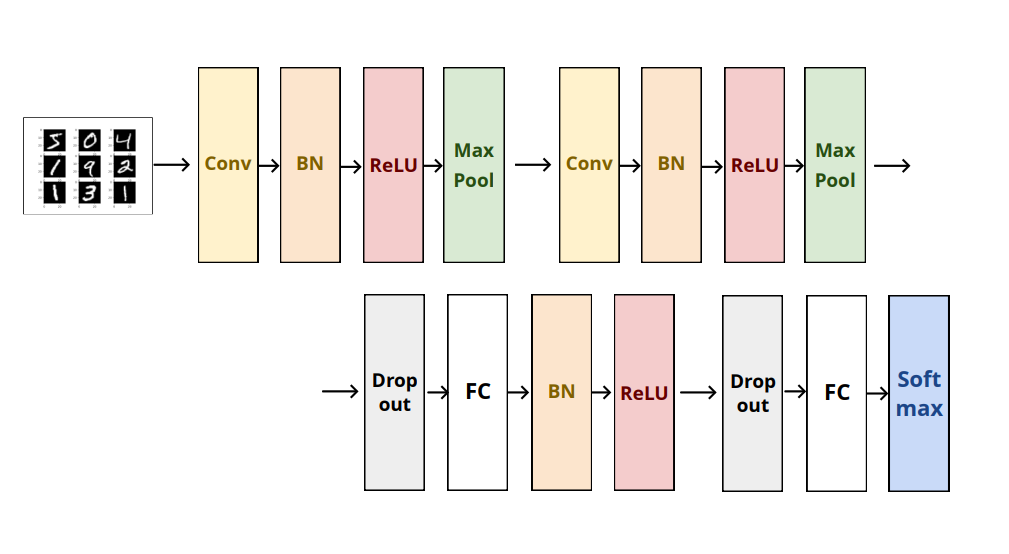

In [9]:
# ConvNet3 - Conv layer 2 + fc layer 2
class ConvNet3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels  = 1, out_channels = 16, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(7*7*32, 512),
            nn.BatchNorm1d(num_features = 512),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) #fc layer 입력 전reshape(미니 배치사이즈, 나머지는 일렬로)
        out = self.fc(out)
        return out

In [10]:
# 모델 생성
model = ConvNet3(num_classes).to(device)

In [11]:
# 손실함수 - Cross entropy loss, optimizer - Adam
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train
---

In [12]:
# train 함수
def train():
    model.train()

    batch_loss_list = []
    progress = ProgressMonitor( length = len(train_dataset) )

    for batch, target in train_loader:
        batch, target = batch.to(device), target.to(device)

        output = model( batch )
        loss = loss_func( output, target )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_list.append(loss.item())
        progress.update(batch.shape[0], sum(batch_loss_list) / len(batch_loss_list))

In [13]:
# test 함수
def test():
    model.eval()
    correct = 0

    with torch.no_grad():
        for batch, target in test_loader:
            batch, target = batch.to(device), target.to(device)

            output = model( batch )

            output = torch.argmax(output, 1)

            correct += (output == target).sum().item()

    acc = 100 * float(correct)/ len(test_dataset)
    print('Test accuracy : {}/{} ({:.2f}%)'.format(correct, len(test_dataset), acc))

### result
---
accuracy 95% 이상의 결과를 만들어 해당부분 스크린샷과 ipynb 파일을 제출해주세요

In [14]:
# main loop
for epoch in range(num_epochs):
    train()
    test()

Loss: 0.1600 60000 / 60000,60000


Test accuracy : 9862/10000 (98.62%)


Loss: 0.0767 60000 / 60000,60000


Test accuracy : 9891/10000 (98.91%)


Loss: 0.0609 60000 / 60000,60000


Test accuracy : 9909/10000 (99.09%)


Loss: 0.0543 60000 / 60000,60000


Test accuracy : 9926/10000 (99.26%)


Loss: 0.0491 60000 / 60000,60000


Test accuracy : 9926/10000 (99.26%)


Loss: 0.0456 60000 / 60000,60000


Test accuracy : 9934/10000 (99.34%)


Loss: 0.0422 60000 / 60000,60000


Test accuracy : 9936/10000 (99.36%)


Loss: 0.0372 60000 / 60000,60000


Test accuracy : 9938/10000 (99.38%)


Loss: 0.0332 60000 / 60000,60000


Test accuracy : 9925/10000 (99.25%)


Loss: 0.0331 60000 / 60000,60000


Test accuracy : 9931/10000 (99.31%)


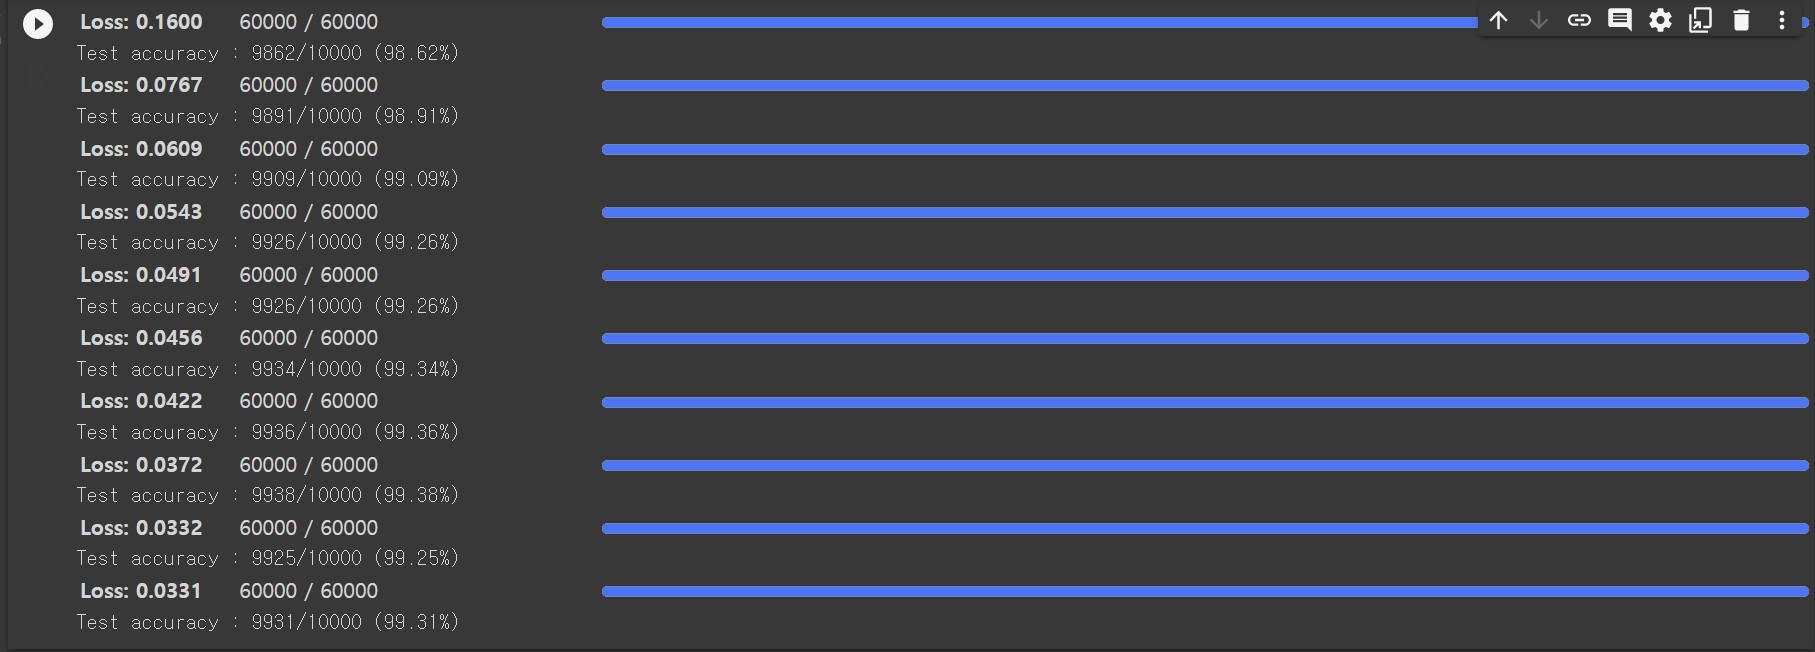